# Desmistificando la transformada de ondeletas

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Febrero 2021 · 5 min read

---

## Resumen

En este ipython notebook estudiamos la transformada de ondeletas (o _wavelets_ como se conocen en inglés). La transformada de ondeletas es un tema interesante de estudiar porque constituyen una alternativa a la transformada de Fourier de corto plazo (STFT, por sus siglas en Inglés) para atenuar el problema del principio de incertidumbre de Heinserberg, que dicta que a mayor resolución frecuencial menor resolución temporal, y viceversa. En la literatura es posible encontrar tanto la transformada de ondeletas continua (CWT, por sus siglas en Inglés), como su versión discreta o _discrete time wavelet transform_ (DTWT), y el banco de filtros asociado a un fenómeno llamado distribución diadica. Además es posible encontrar librerías que implementan la DTWT para su uso en el análisis de frecuencias. Explicamos la teoría básica y varios ejemplo de análisis.

# Introducción
En construcción...

# Definición de ondeleta

Una ondeleta se define como una señal de energía finita y corta duración, que debe cumplir dos condiciones. La primera es tener media cero [2]:

$$
\int_{-\infty}^{\infty}{\psi(t)dt} = 0,
$$

y la segunda, es satisfacer el principio de admisibilidad (tener energia finita):

$$
C_{\psi} = \int_{-\infty}^{\infty}{\frac{|\Psi(\omega)|^2}{|\omega|}d\omega} < \infty,
$$

donde $\Psi(\omega)=\mathscr{F}\{\psi(t)\}$, es decir, la transformada de Fourier de la ondeleta en términos de radianes por segundo (recordando que $\omega=2\pi f$, donde $f \in \mathbb{R}$ la frecuencia en hercios). Un ejemplo de una ondeleta es la función Ricker u _ondeleta sombrero_, que se define como sigue [1]:

$$
\psi(t) = \frac{2}{\sqrt{3\sigma}\pi^{1/4}} \left({1-{\left({\frac{t}{\sigma}}\right)}^2}\right) e^{-\frac{t^2}{2\sigma^2}},
$$

donde $\sigma \in \mathbb{R}$ controlar la amplitud del lóbulo principal y $t \in \mathbb{R}$ representa el tiempo continuo. Gráficamente, la ondeleta sombrero se observa como sigue:

Populating the interactive namespace from numpy and matplotlib


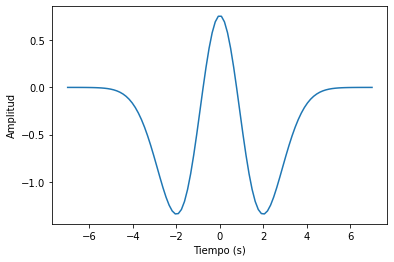

In [2]:
%pylab inline
from scipy import signal
import numpy as np

def sombrero(x,sigma=1.3):
    return (2/(np.sqrt(3*sigma)*np.pi**0.25)) * (1-(x*sigma)**2) * (np.exp(-(x**2)/(2*sigma**2)))

t = np.linspace(-7,7,100)
plt.plot(t,sombrero(t))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

A partir de una función como esta, es posible definir la _ondeleta madre_ que permite derivar otras ondeletas de la misma forma haciendo uso de una serie de escalamientos y desplazamientos (definidos según los parámetros $a$ y $b$, respectivamente):

$$
\psi_{a,b}(t) = \frac{1}{\sqrt{a}}\,\psi\left(\frac{t-b}{a}\right).
$$

Acá hacemos un escalamiento por $0.5$ s y un desplazamiento por $4$ s:

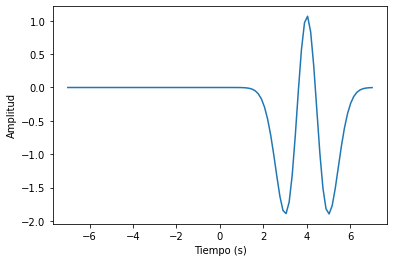

In [3]:
def ondeletaMadre(t,a,b,ondeletaFunc):
    return ondeletaFunc((t-b)/a) * 1.0/np.sqrt(a)

plt.plot(t,ondeletaMadre(t,a=0.5,b=4,ondeletaFunc=sombrero)) # retrasar 2 segundos y cambiar ancho a la mitad
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

# Transformada continua de ondeleta

La ondeleta madre permite definir otro concepto llamado la _transformada de ondeleta continua_ (CWT, por sus siglas en inglés) que permite analizar una señal mediante la siguiente ecuación [2]:

$$
\text{CWT}_f(a,b) = \int_{-\infty}^{\infty}{x(t)\,\psi^{*}_{a,b}(t)dt},  
$$

donde el operador $\cdot^{*}$ representa el conjugado complejo definido como $(a+bi)^{*}=a-bi$. En este punto, el lector algido notará que la ecuación anterior no es otra cosa de la correlación entre la función ondeleta (escalada y trasladada) y la función $x$; puede decirse que lo mismo ocurre con la _transformada de Fourier_, pero en ella se usan exponenciales complejas (senos o cosenos). 

El código para calcular la CWT se vería como sigue:

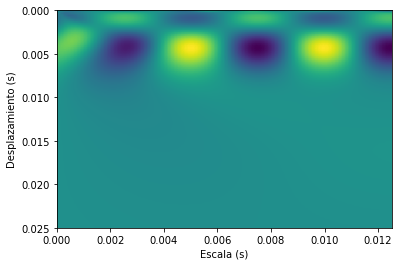

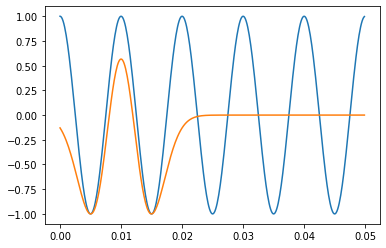

In [10]:
def CWT(f,a,b,ondeleta=sombrero):
    return np.dot(ondeletaMadre(np.arange(0,len(f)),a,b,ondeleta), f)

F0 = 100 # frec. fundamental (Hz)
Fs = 8e3 # frec. muestreo (Hz)
N = int(5*Fs/F0) # mostrar 5 periodos de la senal

n = np.arange(0,N)
y = np.cos(2*np.pi*F0/Fs*n) # f=F0/Fs: frecuencia discreta

A = np.linspace(0.1,100,100)
B = np.linspace(0.1,200,100)
F = np.zeros([len(A),len(B)])
for iA in range(0,len(A)):
    for iB in range(0,len(B)):
        F[iA,iB]=CWT(y,A[iA],B[iB])
       
figure()
plt.imshow(F, aspect='auto', extent=[0, A[-1]/Fs, B[-1]/Fs,0]) 
plt.ylabel('Desplazamiento (s)')
plt.xlabel('Escala (s)')
show()

figure()
t=n/Fs
plt.plot(t,y)
w = ondeletaMadre(t,a=0.0025,b=2*0.005,ondeletaFunc=sombrero)
plt.plot(t,w/max(abs(w)))
show()

# Transformada discreta de ondeletas

La transformada de ondeletas también tiene una versión discreta, definida como sigue [3,4]:

$$
\text{DTWT}_f[a,b] = \frac{1}{\sqrt{b}} \sum_{m=0}^{p-1}{x[t_m] \, \psi\big[\frac{t_m-a}{b}\big]},  
$$

donde:
* $a=K2^{-j}$,
* $b=2^{-j}$,
* $j \in \mathbb{N}$ es el índice de escalamiento,
* $K \in \mathbb{N}$ es el índice de la ondeleta.

Como $a$ y $b$ son potencias de dos, se dice que la transformada es diádica; esto además define los filtros escalados y desplazados como un banco de filtros de la siguiente forma:

<img src="img/bancoFiltros.jpg" width="40%"></img>

A nivel computacional, este análisis puede optimizarse de la siguiente manera:

<img src="img/bancoFiltros2.jpg" width="60%"></img>

donde $H$ es un filtro pasa-altas, $L$ es un filtro pasa-bajas obtenido de $H$ aplicando la técnica de espejo en cuadratura (ver https://es.wikipedia.org/wiki/Filtro_espejo_en_cuadratura), $H_{\text{up}}$ y $L_{\text{up}}$ son filtros adicionales pasa-altas y pasa-bajas con decimación, $cD*$ y $cA*$ son los coeficientes de la transformada, y la parte derecha del gráfico es una etapa de síntesis que no nos interesa tanto explicar en este ipython notebook. 

# Empleando librerias existentes

La librería Scipy provee la función `signal.CWT` mientras que Obspy provee la función `obspy.signal.tf_misfit.CWT`, la primera puede usarse para graficar la CWT mientras que la segunda permite graficar un escalograma (el análogo del espectrograma o transforma de Fourier de corto plazo de la transformada wavelet). A diferencia de un espectrograma, el escalograma no está limitado por el principio de Incertidumbre de Heisenberg aplicado a señales, que dice que a mayor resolución temporal, menor resolución frecuencial y viceversa. Esto ocurre por otro principio de las ondeletas llamado el principio de multiresolución (ver https://en.wikipedia.org/wiki/Multiresolution_analysis), que entre otras cosas estipula que a frecuencias bajas la CWT aplica una ventana de análisis más larga, y para frecuencias altas, una ventana de análisis más corta.

<img src="img/multiresolution.jpg" width="50%"></img>

Ahora, aplicamos ambas librearías a la señal que definimos en las sección anterior:

(31, 400)


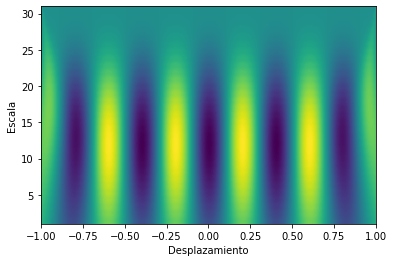

In [11]:
widths = np.arange(1, 32)
cwtmatr = signal.cwt(y, wavelet=signal.ricker, widths=widths) # Continuous wavelet transform, Ricker=mexican hat

print(cwtmatr.shape)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], aspect='auto' # cmap='PRGn',
           ,vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.xlabel('Desplazamiento')
plt.ylabel('Escala')
plt.show()

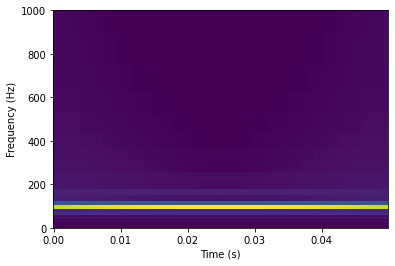

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import obspy # pip3 install obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

scalogram = cwt(st=y, dt=1.0/Fs, w0=32, fmin=0.0001, fmax=Fs/2) # morlet

ax = plt.figure().add_subplot(111)
x_axis, y_axis = np.meshgrid(t,np.logspace(np.log10(0.0001), np.log10(Fs/2), scalogram.shape[0]))
ax.pcolormesh(x_axis, y_axis, np.abs(scalogram), cmap=obspy_sequential, shading='auto')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.ylim([0,1000])
plt.show()

# Conclusiones
En construcción...

# Referencias

1. Wikipedia contributors. (2021, February 17). Mexican hat wavelet. In Wikipedia, The Free Encyclopedia. Retrieved 00:05, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Mexican_hat_wavelet&oldid=1007284050

2. M. Vetterli, J. Kovacevic. Wavelets and Subband Coding. Orignally published in 1995 by Prentice Hall PTR, Englewood Cliffs, New Jersey. Reissued by authors in 2007.

3. Wikipedia contributors. (2021, March 3). Correlation and dependence. In Wikipedia, The Free Encyclopedia. Retrieved 00:47, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Correlation_and_dependence&oldid=1010073167

4. Andrew Nicoll. The Wavelet Transform for Beginners. URL: https://youtu.be/kuuUaqAjeoA (consultado por última vez el 05/22/21)

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2021,
  author = {Juan M. Fonseca-Solís},
  title = {Desmistificando la transformada de ondeletas},
  year = 2021,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.wavelets.html},
  urldate = {}
}
```